In [13]:
import requests
import pandas as pd

url = "https://archive-api.open-meteo.com/v1/era5"
params = {
    "latitude": 30.0444,  # Latitude for Cairo
    "longitude": 31.2357,  # Longitude for Cairo
    "start_date": "1971-01-01",  # Start date
    "end_date": "2014-12-31",    # End date
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
    "timezone": "Africa/Cairo"
}

response = requests.get(url, params=params)
weather_data = response.json()

daily_weather = pd.DataFrame(weather_data['daily'])

daily_weather['year'] = pd.to_datetime(daily_weather['time']).dt.year
annual_weather = daily_weather.groupby('year').agg({
    'temperature_2m_max': 'mean',
    'temperature_2m_min': 'mean',
    'precipitation_sum': 'sum'
}).reset_index()

print(annual_weather)

    year  temperature_2m_max  temperature_2m_min  precipitation_sum
0   1971           28.176438           15.107397               61.9
1   1972           28.315574           15.412295               35.4
2   1973           28.507397           14.536986               13.1
3   1974           28.567671           14.956438               38.9
4   1975           28.421096           14.837260               51.4
5   1976           28.297541           14.774044                9.2
6   1977           28.612603           14.778630               22.0
7   1978           28.867945           14.746849               23.9
8   1979           28.992603           15.364384                9.0
9   1980           28.378142           14.701639               12.7
10  1981           28.227945           14.556986                4.6
11  1982           27.796438           14.278082               15.1
12  1983           27.501918           14.084658               13.7
13  1984           28.185519           14.351639

In [17]:
# Electricity usage data
electricity_data = pd.read_csv('/content/egypt_electricity_usage_per_capita_1971_2014.csv')

# Population data
population_data = pd.read_csv('/content/egypt_population_1971_2014.csv')

# gdp data
gdp_data = pd.read_csv('/content/egypt_gdp_1971_2014.csv')

annual_weather.rename(columns={'year': 'Year'}, inplace=True)
# Merge all data
df = electricity_data.merge(population_data, on='Year').merge(gdp_data, on='Year').merge(annual_weather, on='Year')

# Print the combined DataFrame
print(df)


    Year  Electricity Usage per Capita (kWh)  Population           GDP  \
0   1971                          202.947640    35555969  8.609283e+09   
1   1972                          199.280125    36330768  9.299638e+09   
2   1973                          196.170468    37120776  1.009853e+10   
3   1974                          216.475588    37930374  9.228963e+09   
4   1975                          238.810072    38775584  1.163218e+10   
5   1976                          272.364659    39649050  1.331599e+10   
6   1977                          306.525640    40577356  1.440081e+10   
7   1978                          320.107668    41576636  1.481170e+10   
8   1979                          344.174385    42632458  1.802057e+10   
9   1980                          378.161053    43748556  2.166991e+10   
10  1981                          413.389232    44899573  2.213608e+10   
11  1982                          452.627737    46088647  2.765517e+10   
12  1983                          496.

In [25]:
X = df[['Population', 'GDP', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum']]
y = df['Electricity Usage per Capita (kWh)']

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 9268.006372554666
R-squared: 0.9580425430990789


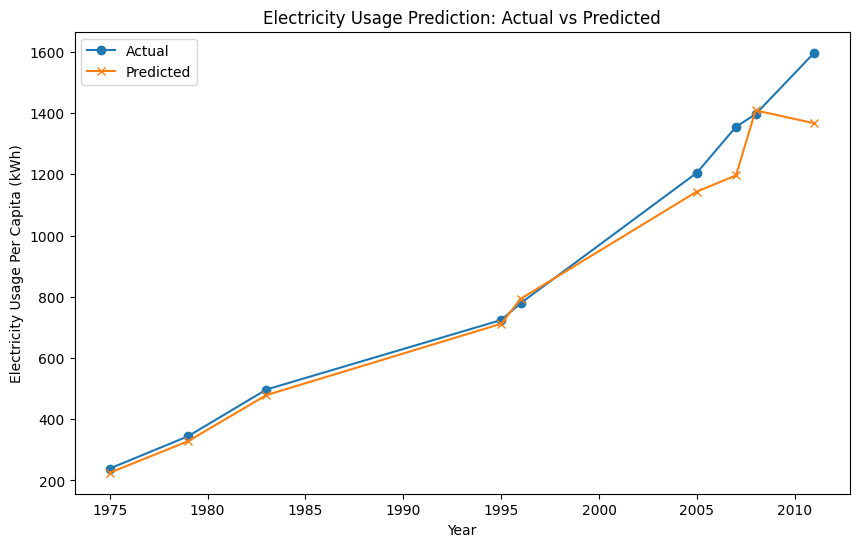

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

X_test_years = df.loc[X_test.index, 'Year']

sorted_indices = X_test_years.argsort()
X_test_years_sorted = X_test_years.iloc[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = pd.Series(y_pred, index=X_test_years).iloc[sorted_indices]

plt.plot(X_test_years_sorted, y_test_sorted, label='Actual', marker='o')
plt.plot(X_test_years_sorted, y_pred_sorted, label='Predicted', marker='x')

plt.xlabel('Year')
plt.ylabel('Electricity Usage Per Capita (kWh)')
plt.title('Electricity Usage Prediction: Actual vs Predicted')
plt.legend()
plt.show()


In [35]:
from datetime import datetime

current_date = datetime.now().strftime('%Y-%m-%d')

url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 30.0444,  # Latitude for Cairo
    "longitude": 31.2357,  # Longitude for Cairo
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
    "timezone": "Africa/Cairo",
    "start_date": current_date,
    "end_date": current_date,
}

response = requests.get(url, params=params)
weather_data = response.json()

current_weather = {
    "temperature_2m_max": weather_data['daily']['temperature_2m_max'][0],
    "temperature_2m_min": weather_data['daily']['temperature_2m_min'][0],
    "precipitation_sum": weather_data['daily']['precipitation_sum'][0],
}

current_weather_df = pd.DataFrame([current_weather])

# Add population for the current year
current_population = 95592324
current_weather_df['Population'] = current_population
current_weather_df['GDP'] = 395926075163.006


print(current_weather_df)


   temperature_2m_max  temperature_2m_min  precipitation_sum  Population  \
0                38.2                25.7                0.0    95592324   

            GDP  
0  3.959261e+11  


In [37]:
current_weather_df = current_weather_df[['Population', 'GDP', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum']]
# Predict electricity usage using the current weather and population data
current_prediction = model.predict(current_weather_df)

print(f'Predicted Electricity Usage Per Capita: {current_prediction[0]}')


Predicted Electricity Usage Per Capita: 1562.4776591300072
